# QRT Asset Allocation Performance Forecasting

This notebook presents a solution for the QRT Asset Allocation Challenge. The goal is to predict whether assets will have positive or negative returns based on historical market data.

## Approach

1. **Feature Engineering**: Create technical indicators and momentum features from raw return data
2. **Model Training**: Compare multiple models (Ridge, Random Forest, LightGBM)
3. **Hyperparameter Tuning**: Use GridSearchCV with time-series aware cross-validation
4. **Prediction**: Generate binary predictions (positive/negative return)

---

## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, GridSearchCV

import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 2. Load Data

In [ ]:
# Load datasets
X_train = pd.read_csv('X_train.csv', index_col='ROW_ID')
X_test = pd.read_csv('X_test.csv', index_col='ROW_ID')
y_train = pd.read_csv('y_train.csv', index_col='ROW_ID')
sample_submission = pd.read_csv('sample_submission.csv', index_col='ROW_ID')

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {X_train.shape[1]}")

In [ ]:
# Preview the data
X_train.head()

Index(['TS', 'ALLOCATION', 'RET_20', 'RET_19', 'RET_18', 'RET_17', 'RET_16',
       'RET_15', 'RET_14', 'RET_13', 'RET_12', 'RET_11', 'RET_10', 'RET_9',
       'RET_8', 'RET_7', 'RET_6', 'RET_5', 'RET_4', 'RET_3', 'RET_2', 'RET_1',
       'SIGNED_VOLUME_20', 'SIGNED_VOLUME_19', 'SIGNED_VOLUME_18',
       'SIGNED_VOLUME_17', 'SIGNED_VOLUME_16', 'SIGNED_VOLUME_15',
       'SIGNED_VOLUME_14', 'SIGNED_VOLUME_13', 'SIGNED_VOLUME_12',
       'SIGNED_VOLUME_11', 'SIGNED_VOLUME_10', 'SIGNED_VOLUME_9',
       'SIGNED_VOLUME_8', 'SIGNED_VOLUME_7', 'SIGNED_VOLUME_6',
       'SIGNED_VOLUME_5', 'SIGNED_VOLUME_4', 'SIGNED_VOLUME_3',
       'SIGNED_VOLUME_2', 'SIGNED_VOLUME_1', 'AVG_DAILY_TURNOVER'],
      dtype='object')

## 3. Feature Definitions

The dataset contains several feature groups:
- **RET_1 to RET_20**: Historical returns for the past 20 days
- **SIGNED_VOLUME_1 to SIGNED_VOLUME_20**: Signed trading volume
- **VOLATILITY_1 to VOLATILITY_20**: Historical volatility
- **AVG_DAILY_TURNOVER**: Average daily turnover

In [ ]:
# Define base feature groups
RET_FEATURES = [f'RET_{i}' for i in range(1, 21)]
SIGNED_VOLUME_FEATURES = [f'SIGNED_VOLUME_{i}' for i in range(1, 21)]
VOLATILITY_FEATURES = [f'VOLATILITY_{i}' for i in range(1, 21)]
TURNOVER_FEATURES = ['AVG_DAILY_TURNOVER']

# Features for Ichimoku indicators
RET_FEATURES_9 = [f'RET_{i}' for i in range(1, 11)]
RET_FEATURES_19 = [f'RET_{i}' for i in range(1, 21)]
REVERSED_RET_FEATURES = [f'RET_{i}' for i in range(20, 0, -1)]


## 4. Feature Engineering

We create several advanced features:
- **Performance metrics**: Rolling averages and relative performance
- **Ichimoku indicators**: Tenkan-sen, Kijun-sen proxies
- **Bollinger Bands**: EMA-based bands and position indicators
- **Chandelier Exit**: Trailing stop distance features
    

In [ ]:
def create_chandelier_features(df, atr_multiplier=2.0):
    """
    Create Chandelier Exit features based on price path reconstruction.
    
    The Chandelier Exit is a volatility-based trailing stop indicator that
    measures the distance from recent highs/lows.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe with return features
    atr_multiplier : float
        Multiplier for ATR-based stop distance (default: 2.0)
    
    Returns
    -------
    DataFrame with new features added
    """
    df = df.copy()
    
    # Reconstruct relative price path from returns (chronological order)
    price_path = (1 + df[REVERSED_RET_FEATURES]).cumprod(axis=1)
    current_price = price_path.iloc[:, -1]
    
    # Find extremes over the price path
    highest_high = price_path.max(axis=1)
    lowest_low = price_path.min(axis=1)
    
    # Use 14-day volatility as ATR proxy
    atr_proxy = df[[f'RET_{i}' for i in range(1, 15)]].std(axis=1)
    
    # Calculate Chandelier Exit levels
    long_stop = highest_high - (atr_proxy * atr_multiplier)
    short_stop = lowest_low + (atr_proxy * atr_multiplier)
    
    # Normalized distance to stop levels
    df['long_chandelier_dist'] = (current_price - long_stop) / (atr_proxy * atr_multiplier + 1e-10)
    df['short_chandelier_dist'] = (short_stop - current_price) / (atr_proxy * atr_multiplier + 1e-10)
    
    return df


In [ ]:
def create_ichimoku_features(df):
    """
    Create Ichimoku Cloud indicator proxies.
    
    - Tenkan-sen: Fast momentum line (9-period midpoint)
    - Kijun-sen: Slow momentum line (20-period midpoint)
    - TK Crossover: Difference between fast and slow lines
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe with return features
    
    Returns
    -------
    DataFrame with Ichimoku features added
    """
    df = df.copy()
    
    # Tenkan-sen proxy (fast line - 9 period)
    df['tenkan_sen_proxy'] = (df[RET_FEATURES_9].max(axis=1) + df[RET_FEATURES_9].min(axis=1)) / 2
    
    # Kijun-sen proxy (slow line - 20 period)
    df['kijun_sen_proxy'] = (df[RET_FEATURES_19].max(axis=1) + df[RET_FEATURES_19].min(axis=1)) / 2
    
    # TK Crossover signal
    df['tk_crossover'] = df['tenkan_sen_proxy'] - df['kijun_sen_proxy']
    
    # Position relative to indicator lines
    df['ret_vs_tenkan'] = df['RET_1'] - df['tenkan_sen_proxy']
    df['ret_vs_kijun'] = df['RET_1'] - df['kijun_sen_proxy']
    
    return df


In [ ]:
def create_bollinger_features(df, periods=[10, 20]):
    """
    Create Bollinger Bands features using EMA.
    
    Bollinger Bands measure volatility and identify overbought/oversold conditions.
    The key feature is the position within the bands (0-1 range, with breakouts > 1 or < 0).
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe with return features
    periods : list
        Periods for EMA calculation (default: [10, 20])
    
    Returns
    -------
    DataFrame with Bollinger Band features added
    """
    df = df.copy()
    
    for period in periods:
        # EMA center line (using transpose to avoid deprecated axis=1)
        ema = df[REVERSED_RET_FEATURES].T.ewm(span=period, adjust=False).mean().T
        df[f'ema_{period}'] = ema.iloc[:, -1]
        
        # Rolling standard deviation
        rolling_std = df[REVERSED_RET_FEATURES].T.rolling(window=period).std().T
        df[f'std_{period}'] = rolling_std.iloc[:, -1]
        
        # Upper and lower bands (2 standard deviations)
        df[f'bband_upper_{period}'] = df[f'ema_{period}'] + 2 * df[f'std_{period}']
        df[f'bband_lower_{period}'] = df[f'ema_{period}'] - 2 * df[f'std_{period}']
        
        # Position within bands (key feature)
        band_width = df[f'bband_upper_{period}'] - df[f'bband_lower_{period}']
        df[f'bband_pct_{period}'] = (df['RET_1'] - df[f'bband_lower_{period}']) / (band_width + 1e-10)
    
    return df


In [ ]:
def create_performance_features(df, windows=[3, 5, 10, 15, 20]):
    """
    Create performance and volatility features over different time windows.
    
    Features include:
    - Average performance over window
    - Performance relative to asset group (TS)
    - Rolling volatility
    - Signed volume volatility
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe with return and volume features
    windows : list
        Time windows for feature calculation (default: [3, 5, 10, 15, 20])
    
    Returns
    -------
    DataFrame with performance features added
    """
    df = df.copy()
    
    for window in windows:
        # Average performance over window
        df[f'avg_perf_{window}'] = df[RET_FEATURES[:window]].mean(axis=1)
        
        # Group average performance (relative to asset group)
        df[f'group_avg_perf_{window}'] = df.groupby('TS')[f'avg_perf_{window}'].transform('mean')
        
        # Performance difference (outperformance vs group)
        df[f'perf_diff_{window}'] = df[f'avg_perf_{window}'] - df[f'group_avg_perf_{window}']
        
        # Rolling volatility
        df[f'rolling_vol_{window}'] = df[RET_FEATURES[:window]].std(axis=1)
        
        # Signed volume volatility
        df[f'volume_vol_{window}'] = df[SIGNED_VOLUME_FEATURES[:window]].std(axis=1)
    
    return df


In [ ]:
def engineer_features(df):
    """
    Apply all feature engineering transformations.
    
    Parameters
    ----------
    df : DataFrame
        Input dataframe with raw features
    
    Returns
    -------
    DataFrame with all engineered features
    """
    df = create_performance_features(df)
    df = create_ichimoku_features(df)
    df = create_bollinger_features(df)
    df = create_chandelier_features(df)
    return df

# Apply feature engineering to both datasets
print("Engineering features...")
X_train = engineer_features(X_train)
X_test = engineer_features(X_test)
print(f"Total features after engineering: {X_train.shape[1]}")


In [ ]:
# Define complete feature list for modeling
ICHIMOKU_FEATURES = ['tenkan_sen_proxy', 'kijun_sen_proxy', 'tk_crossover', 'ret_vs_tenkan', 'ret_vs_kijun']
BBAND_FEATURES = ['bband_pct_10', 'bband_pct_20']
CHANDELIER_FEATURES = ['long_chandelier_dist', 'short_chandelier_dist']
PERF_FEATURES = [f'avg_perf_{w}' for w in [3, 5, 10, 15, 20]]
GROUP_PERF_FEATURES = [f'group_avg_perf_{w}' for w in [3, 5, 10, 15, 20]]
PERF_DIFF_FEATURES = [f'perf_diff_{w}' for w in [3, 5, 10, 15, 20]]
ROLLING_VOL_FEATURES = [f'rolling_vol_{w}' for w in [3, 5, 10, 15, 20]]
VOLUME_VOL_FEATURES = [f'volume_vol_{w}' for w in [3, 5, 10, 15, 20]]

# Combine all features
ALL_FEATURES = (
    RET_FEATURES + 
    SIGNED_VOLUME_FEATURES + 
    VOLATILITY_FEATURES + 
    TURNOVER_FEATURES +
    ICHIMOKU_FEATURES +
    BBAND_FEATURES +
    CHANDELIER_FEATURES +
    PERF_FEATURES +
    GROUP_PERF_FEATURES +
    PERF_DIFF_FEATURES +
    ROLLING_VOL_FEATURES +
    VOLUME_VOL_FEATURES
)

# Filter to features that exist in both train and test
FEATURES = [f for f in ALL_FEATURES if f in X_train.columns and f in X_test.columns]
FEATURES = list(dict.fromkeys(FEATURES))  # Remove duplicates while preserving order

print(f"Features used for modeling: {len(FEATURES)}")

## 5. Model Training

We train and compare three models:
1. **Ridge Regression** - Linear baseline
2. **Random Forest** - Ensemble of decision trees
3. **LightGBM** - Gradient boosting with hyperparameter tuning

### 5.1 Ridge Regression (Baseline)

In [ ]:
# Prepare data
X_train_matrix = X_train[FEATURES].fillna(0).values
y_train_values = y_train['target'].fillna(0).values
X_test_matrix = X_test[FEATURES].fillna(0).values

# Train Ridge model
ridge_model = Ridge(alpha=1e-2, fit_intercept=False)
ridge_model.fit(X_train_matrix, y_train_values)

# Generate predictions
preds_ridge = ridge_model.predict(X_test_matrix)
preds_ridge_df = pd.DataFrame(preds_ridge, index=sample_submission.index, columns=['target'])

# Save predictions
(preds_ridge_df['target'] > 0).astype(int).to_csv('preds_ridge.csv')
print("Ridge predictions saved to 'preds_ridge.csv'")

In [ ]:
### 5.2 Random Forest with Cross-Validation

# Random Forest configuration
RF_PARAMS = {
    'n_estimators': 100,
    'max_depth': 32,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
}

# Time-series aware cross-validation (split by dates)
train_dates = X_train['TS'].unique()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

scores = []
models_rf = []

print("Training Random Forest with cross-validation...")
print("-" * 50)

for fold, (train_idx, val_idx) in enumerate(kf.split(train_dates), 1):
    # Split by dates to avoid data leakage
    train_dates_fold = train_dates[train_idx]
    val_dates_fold = train_dates[val_idx]
    
    train_mask = X_train['TS'].isin(train_dates_fold)
    val_mask = X_train['TS'].isin(val_dates_fold)
    
    X_fold_train = X_train.loc[train_mask, FEATURES].fillna(0)
    y_fold_train = y_train.loc[train_mask, 'target']
    X_fold_val = X_train.loc[val_mask, FEATURES].fillna(0)
    y_fold_val = y_train.loc[val_mask, 'target']
    
    # Train model
    model = RandomForestRegressor(**RF_PARAMS)
    model.fit(X_fold_train, y_fold_train)
    
    # Evaluate
    y_pred = model.predict(X_fold_val)
    score = accuracy_score((y_fold_val > 0).astype(int), (y_pred > 0).astype(int))
    
    models_rf.append(model)
    scores.append(score)
    print(f"Fold {fold}: Accuracy = {score * 100:.2f}%")

# Summary statistics
mean_score = np.mean(scores) * 100
std_score = np.std(scores) * 100
print("-" * 50)
print(f"Mean Accuracy: {mean_score:.2f}% (+/- {std_score:.2f}%)")

In [ ]:
# Plot feature importances
feature_importances_rf = pd.DataFrame(
    [model.feature_importances_ for model in models_rf],
    columns=FEATURES
)

plt.figure(figsize=(12, 10))
plt.title('Random Forest Feature Importances', fontsize=14)
sns.barplot(
    data=feature_importances_rf,
    orient='h',
    order=feature_importances_rf.mean().sort_values(ascending=False).index
)
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Fold 1 - Accuracy: 51.10%
Fold 2 - Accuracy: 51.81%
Fold 3 - Accuracy: 51.69%
Fold 4 - Accuracy: 52.05%
Fold 5 - Accuracy: 52.04%
Accuracy: 51.74% [51.39 ; 52.08] (+- 0.34)


<Axes: >

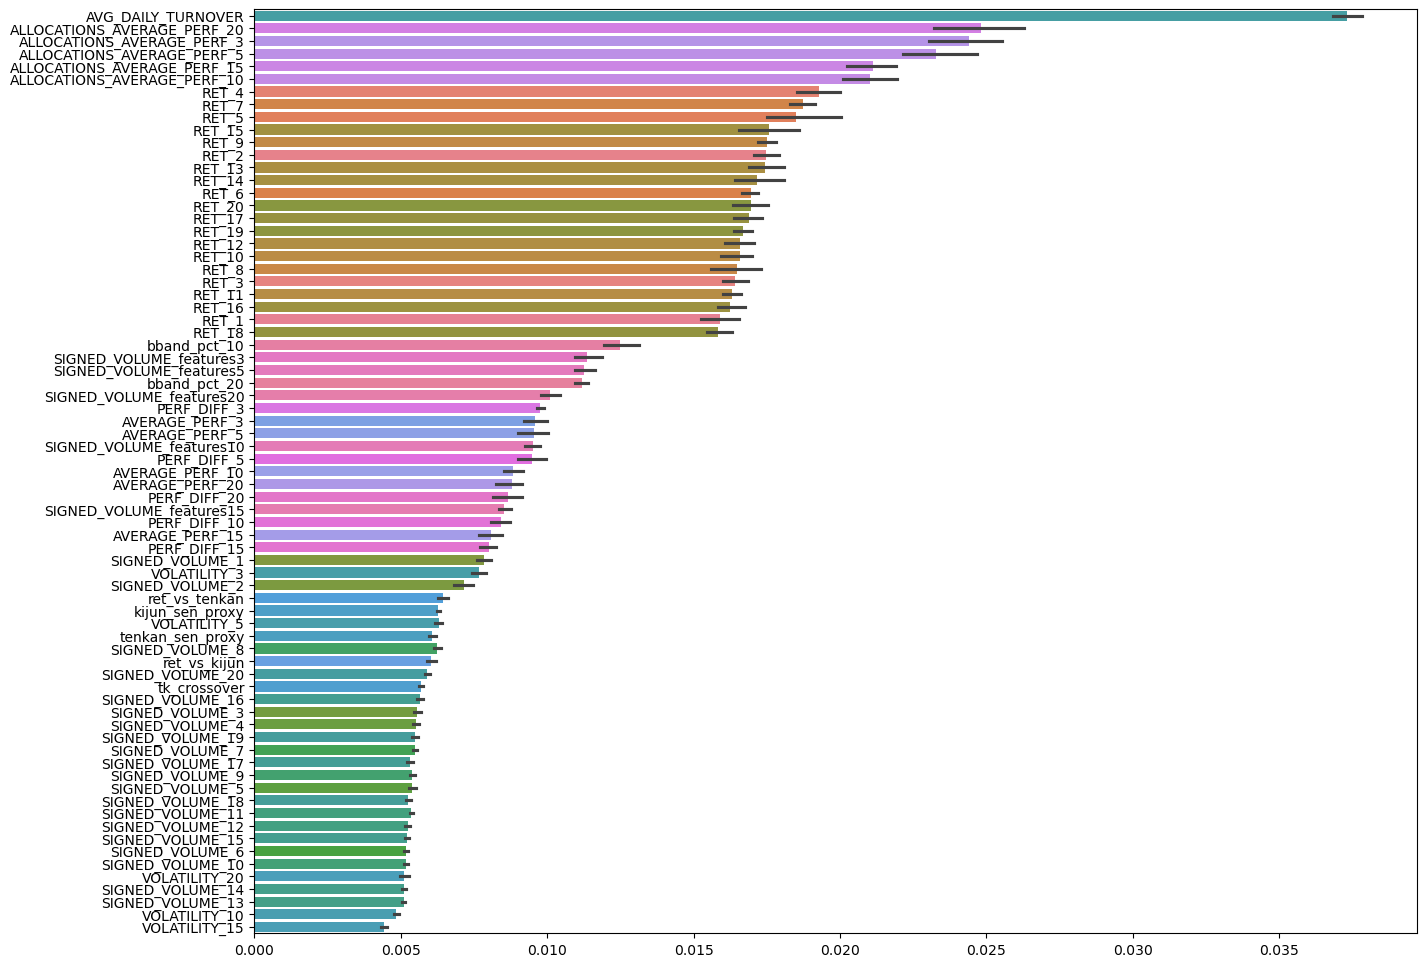

In [ ]:
# Train final Random Forest on all data
rf_final = RandomForestRegressor(**RF_PARAMS)
rf_final.fit(X_train[FEATURES].fillna(0), y_train['target'])

# Generate predictions
preds_rf = rf_final.predict(X_test[FEATURES].fillna(0))
preds_rf_df = pd.DataFrame(preds_rf, index=sample_submission.index, columns=['target'])

# Save predictions
(preds_rf_df['target'] > 0).astype(int).to_csv('preds_rf.csv')
print("Random Forest predictions saved to 'preds_rf.csv'")


In [ ]:
### 5.3 LightGBM with Hyperparameter Tuning

In [ ]:
# Define parameter grid for GridSearchCV
PARAM_GRID = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.01, 0.05],
    'max_depth': [5, 7],
    'num_leaves': [20, 31]
}

# Create time-series aware CV iterator
train_dates = X_train['TS'].unique()
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

# Convert date-based splits to row indices for GridSearchCV
train_indices = np.arange(len(X_train))
cv_iterator = []

for train_date_idx, val_date_idx in kf.split(train_dates):
    train_dates_fold = train_dates[train_date_idx]
    val_dates_fold = train_dates[val_date_idx]
    
    train_mask = X_train['TS'].isin(train_dates_fold)
    val_mask = X_train['TS'].isin(val_dates_fold)
    
    cv_iterator.append((train_indices[train_mask], train_indices[val_mask]))

# Prepare binary target for classification
y_train_binary = (y_train['target'] > 0).astype(int)

print(f"Parameter combinations to test: {np.prod([len(v) for v in PARAM_GRID.values()])}")
print(f"Cross-validation folds: {n_splits}")

# Run GridSearchCV
lgbm_classifier = lgbm.LGBMClassifier(random_state=RANDOM_STATE, verbosity=-1)

grid_search = GridSearchCV(
    estimator=lgbm_classifier,
    param_grid=PARAM_GRID,
    cv=cv_iterator,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Running hyperparameter search...")
grid_search.fit(X_train[FEATURES].fillna(0), y_train_binary)

print("\n" + "=" * 50)
print("BEST PARAMETERS FOUND:")
print("=" * 50)
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV Accuracy: {grid_search.best_score_ * 100:.2f}%")

In [ ]:
# Train final LightGBM model with best parameters
print("Training final LightGBM model with optimized parameters...")

lgbm_final = lgbm.LGBMRegressor(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=-1,
    **grid_search.best_params_
)

lgbm_final.fit(X_train[FEATURES].fillna(0), y_train['target'])

# Generate predictions
preds_lgbm = lgbm_final.predict(X_test[FEATURES].fillna(0))
preds_lgbm_df = pd.DataFrame(preds_lgbm, index=sample_submission.index, columns=['target'])

# Save predictions
(preds_lgbm_df['target'] > 0).astype(int).to_csv('preds_lgbm_optimized.csv')
print("LightGBM predictions saved to 'preds_lgbm_optimized.csv'")


Lancement de la recherche des meilleurs paramètres pour LightGBM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[LightGBM] [Info] Number of positive: 72689, number of negative: 71481
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 144170, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504189 -> initscore=0.016758
[LightGBM] [Info] Start training from score 0.016758
[LightGBM] [Info] Number of positive: 72290, number of negative: 71880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 144170, number of used features: 75
[LightGBM] [In

In [ ]:
# Plot LightGBM feature importances
feature_importance_lgbm = pd.DataFrame({
    'feature': FEATURES,
    'importance': lgbm_final.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.title('LightGBM Feature Importances', fontsize=14)
sns.barplot(
    data=feature_importance_lgbm,
    x='importance',
    y='feature'
)
plt.xlabel('Importance (Gain)')
plt.tight_layout()
plt.show()

Entraînement du modèle final sur tout le jeu de données avec les paramètres optimisés...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19125
[LightGBM] [Info] Number of data points in the train set: 180245, number of used features: 75
[LightGBM] [Info] Start training from score 0.000012

Fichier 'preds_lgbm_optimized.csv' généré avec succès !


## 6. Results Summary

Three prediction files have been generated:
- `preds_ridge.csv` - Ridge regression baseline
- `preds_rf.csv` - Random Forest predictions  
- `preds_lgbm_optimized.csv` - LightGBM with tuned hyperparameters


In [ ]:
# Compare prediction distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

predictions = [
    ('Ridge', preds_ridge_df['target']),
    ('Random Forest', preds_rf_df['target']),
    ('LightGBM', preds_lgbm_df['target'])
]

for ax, (name, preds) in zip(axes, predictions):
    positive_pct = (preds > 0).mean() * 100
    ax.hist(preds, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', label='Decision boundary')
    ax.set_title(f'{name}\n({positive_pct:.1f}% positive predictions)')
    ax.set_xlabel('Predicted Value')
    ax.set_ylabel('Count')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "=" * 60)
print("SUBMISSION FILES READY")
print("=" * 60)
print("\nGenerated files:")
print("  - preds_ridge.csv")
print("  - preds_rf.csv")
print("  - preds_lgbm_optimized.csv")
print("\nRecommendation: Submit 'preds_lgbm_optimized.csv' for best results.")